<a href="https://colab.research.google.com/github/masve123/Deep-Learning-textual-reviews/blob/main/Deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project for deep learning...


In [ ]:
# Checking if kaggle is installed, otherwise install it in our environment
!pip show kaggle || pip install kaggle

# !pip show tensorflow || pip install tensorflow

Name: kaggle
Version: 1.5.13
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


In [ ]:
# Importing dependencies

%matplotlib inline

import json
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


import os
import tensorflow_datasets as tfds
from typing import Generator, List, Dict, Any

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
from IPython.display import display, Javascript, clear_output, HTML
from google.colab import output
from PIL import Image
import io, base64
import PIL


print("Tensorflow version " + tf.__version__)

np.set_printoptions(precision=3, threshold=11)

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0') #, figsize=(16,9)
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__),
                                   "mpl-data/fonts/ttf")

Tensorflow version 2.12.0


Enabling connection to TPU for efficient computation:

In [ ]:
use_tpu = True # Set this to True if you want to use TPU

# Detect hardware and connect TPU
if use_tpu:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        tpu = None

    # Select appropriate distribution strategy
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print('Connected to TPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Not connected to TPU')
else:
    strategy = tf.distribute.get_strategy()
    print('TPU connection is disabled')

print("REPLICAS: ", strategy.num_replicas_in_sync)

Not connected to TPU
REPLICAS:  1


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via Runtime > Change runtime type in the menu. Then select High-RAM in the Runtime shape dropdown. After, re-execute the code cell.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Train a neural network

- Purpose: predict the rating of a review starting from its textual contents.

In [ ]:
# Husk å bytte tilbake til 'xxxxxx'

# Importing project file directly from Kaggle API
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d yelp-dataset/yelp-dataset

yelp-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzipping all our data as it is in the zip-format
!unzip '*.zip'

!ls

Archive:  yelp-dataset.zip
replace Dataset_User_Agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset_User_Agreement.pdf	     yelp_academic_dataset_checkin.json
keras_tuner_text_classification      yelp_academic_dataset_review.json
new_tuner_directory		     yelp_academic_dataset_tip.json
sample_data			     yelp_academic_dataset_user.json
yelp_academic_dataset_business.json  yelp-dataset.zip


# Data organization


In [ ]:
# Our dataset is very big
# Hence, we use a data generator function in order to balance overall data size and processing time
# Using the tensorflow data pipeline we load our data into chunks, where each chunk in chunks
# Represents one tensorflow dataset

AUTO = tf.data.experimental.AUTOTUNE

def chunk_generator(file_path: str, chunk_size: int) -> Generator[List[Dict[str, Any]], None, None]:
    data_chunk = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data_chunk.append(json.loads(line))
            except json.JSONDecodeError:
                continue

            if len(data_chunk) == chunk_size:
                yield data_chunk
                data_chunk = []

        if data_chunk:
            yield data_chunk


def load_dataset(data_chunk: List[Dict[str, Any]]) -> tf.data.Dataset:
    # Convert the data_chunk to a DataFrame, and then to a dictionary of arrays
    data_chunk_df = pd.DataFrame(data_chunk)
    data_chunk_dict = {col: data_chunk_df[col].values for col in data_chunk_df.columns}

    # Convert the data_chunk to a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(data_chunk_dict)
    return dataset

def get_training_dataset(data_gen, batch_size, buffer_size=10000):
    # Load the first chunk for training
    train_data_chunk = next(data_gen)
    train_dataset = load_dataset(train_data_chunk)

    # Shuffle, batch and prefetch
    train_dataset = train_dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(AUTO)

    return train_dataset

def get_validation_dataset(data_gen):
    # Load the second chunk for validation
    valid_data_chunk = next(data_gen)
    valid_dataset = load_dataset(valid_data_chunk)

    # Batch the validation dataset
    valid_dataset = valid_dataset.batch(len(valid_data_chunk))

    return valid_dataset

def get_test_dataset(data_gen):
    # Load the third chunk for testing
    test_data_chunk = next(data_gen)
    test_dataset = load_dataset(test_data_chunk)

    # Batch the test dataset
    test_dataset = test_dataset.batch(len(test_data_chunk))

    return test_dataset


# Parameters
batch_size = 128
chunk_size = 10000  # adjust based on the size of your data
file_path = 'yelp_academic_dataset_review.json'

# Create generator
data_gen = chunk_generator(file_path, chunk_size)

# Create training and validation datasets
training_dataset = get_training_dataset(data_gen, batch_size=batch_size)
validation_dataset = get_validation_dataset(data_gen)

# Create test dataset. This is only to be used once
test_dataset = get_test_dataset(data_gen)

In [ ]:
# This loop will keep loading chunks of data into memory.
# When we want to start preprocessing and training, we can use the 'chunks' variable.
# chunks is a list where each element is a tf.data.Dataset object representing a chunk of data.

# it is somewhat slow

chunks = []
for chunk in data_gen:
    dataset_chunk = load_dataset(chunk)
    chunks.append(dataset_chunk)

    # we don't load all the chunks as it is not needed and we need to keep
    # the system RAM down. This can be scaled accordingly
    if len(chunks) == 2:
      break

In [ ]:
# Taking a look at our features
for batch in training_dataset.take(1):  # Taking only one batch from the dataset
    # batch is a dictionary where the key is the feature name
    # and the value is a batch of data for that feature
    print("Feature names in the dataset:\n", batch.keys())
    break  # Breaking after the first batch

Feature names in the dataset:
 dict_keys(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'])


Given the columns in the dataset, it seems we are working with a multi-class classification problem, where the target variable is the 'stars' column which contains integer values from 1 to 5 (or another range) representing the ratings.

In [ ]:
for batch in training_dataset.take(1):  # Take 1 batch from the dataset
    # Looking at feature 'stars' to find range
    # We are trying to predict the rating of a review.
    stars = batch['stars'].numpy()  # Accessing 'stars' feature
    funny = batch['funny'].numpy()
    useful = batch['useful'].numpy()
    cool = batch['cool'].numpy()
    break

print(f"The star ratings are in the range {stars.min()}-{stars.max()}\n")
print(f"The funny ratings are in the range {funny.min()}-{funny.max()}\n")
print(f"The useful ratings are in the range {useful.min()}-{useful.max()}\n")
print(f"The cool ratings are in the range {cool.min()}-{cool.max()}\n")

The star ratings are in the range 1.0-5.0

The funny ratings are in the range 0-8

The useful ratings are in the range 0-13

The cool ratings are in the range 0-14



In [ ]:
# Counter to limit the number of samples to display
num_samples_to_display = 2
counter = 0

for batch in training_dataset.take(1):  # Take 1 batch from the dataset
    # Looking at two features 'text' and 'stars'
    texts = batch['text'].numpy()   # Accessing 'text' feature
    stars = batch['stars'].numpy()  # Accessing 'stars' feature

    # Iterate through the 'text' and 'stars' in the batch
    for text, star in zip(texts, stars):
        # Print the text and star
        print(f"Text: {text.decode('utf-8')}, Star: {star}\n")

        # Increment counter
        counter += 1

        # Break the loop if the number of desired samples is reached
        if counter >= num_samples_to_display:
            break

    # Break the outer loop to stop fetching more batches
    if counter >= num_samples_to_display:
        break


Text: David Bridal should include alterations with their dress price. I think they  running a business within a business. People pay $500 for a dress and then $500 for alterations. That's not right. Make the dress right to begging with..Sizes were not normal. I ordered size 2, when I had to reorder size 0 and still had alterations to do. And I thought I'm in a great shape.. It took me at least 3 months to get it done. Good I started shopping for my wedding dress half a year in advance... Look for a better place., Star: 2.0

Text: We are choice rewards members and this by far is the worst property that we have ever stayed at and we travel a lot.  I wasted my reward points staying there because their pictures of the property were so deceiving. There was mold all over the bathroom light and ceiling.  Chunks of drywall missing from the walls.  The bathroom smelled like urine.  Their were people smoking,  screaming and running down the halls way after 10 pm and then back at it at 7am. We we

# Data analysis

In [ ]:
# Convert the first chunk to a DataFrame
first_chunk = chunks[0]
first_chunk_as_dict = {}
for feature in first_chunk.element_spec.keys():
    first_chunk_as_dict[feature] = []

# Iterate through the items in the chunk and build a dictionary
for item in first_chunk.as_numpy_iterator():
    for feature in item.keys():
        first_chunk_as_dict[feature].append(item[feature])

# Convert the dictionary to a DataFrame
first_chunk_df = pd.DataFrame(first_chunk_as_dict)

# View the first few rows of the DataFrame
print(first_chunk_df.head())

                   review_id                    user_id  \
0  b'3g2H3grOcCEngesXkaZ6yA'  b'vBO5OY159gfFpeZtSs4dlw'   
1  b'Qwzoc0Ia6R1HacUrhRXW0A'  b'Ont-hQG8TG5LTN29KAUvvA'   
2  b'pnA8yxQy667hQTgo4UX9xg'  b'RR02_O9e5rPzruTUGWt9Ag'   
3  b'5qCgw8hLa23OYzUpM7XJ2g'  b'eBH9-CdtLcOQ6Znp7VQVJQ'   
4  b'CjG3j36PWWmgimsapqCRBw'  b'ZHnn0Foz304q6bGwQP_0uA'   

                 business_id  stars  useful  funny  cool  \
0  b'D22mY6Lmf_32hh5-ESXFPw'    5.0       2      0     1   
1  b'Ugoyu-TIppruxRTkbej3lA'    1.0       1      0     0   
2  b'4WdDY97x4GdMYtyk1KQMnw'    4.0       0      0     0   
3  b'NFFS6Qow43IRG6dRPgZCzQ'    4.0       1      0     1   
4  b'cB_9eHHfo9me96cZup-lZQ'    5.0       5      3     4   

                                                text                    date  
0  b"This place is fantastic. I was apprehensive ...  b'2013-08-18 03:13:06'  
1  b"I did not enjoy my food here. The fish was f...  b'2014-04-03 14:48:37'  
2  b"The pho is EXCELLENT and so is the service

In [ ]:
# Description of a sample
print(first_chunk_df.describe())

              stars        useful        funny          cool
count  10000.000000  10000.000000  10000.00000  10000.000000
mean       3.844900      0.911900      0.25310      0.348000
std        1.349083      1.899184      1.01496      1.143952
min        1.000000      0.000000      0.00000      0.000000
25%        3.000000      0.000000      0.00000      0.000000
50%        4.000000      0.000000      0.00000      0.000000
75%        5.000000      1.000000      0.00000      0.000000
max        5.000000     48.000000     38.00000     49.000000


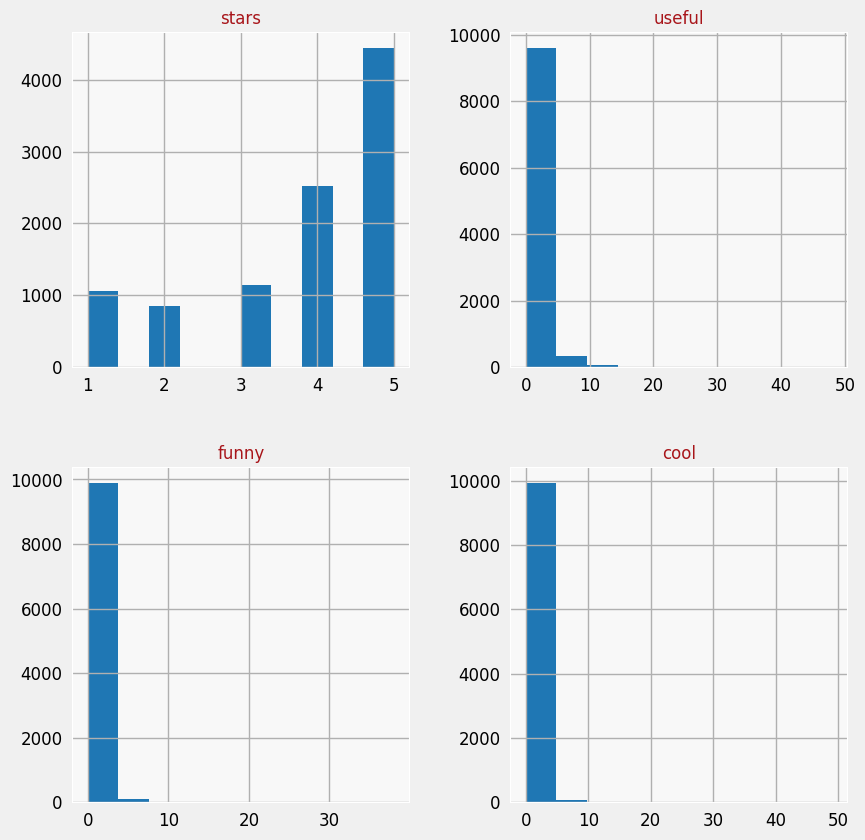

In [ ]:
# Histograms
first_chunk_df.hist(figsize=(10, 10))
plt.show()

<ipython-input-15-ddda6481490f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = first_chunk_df.corr()


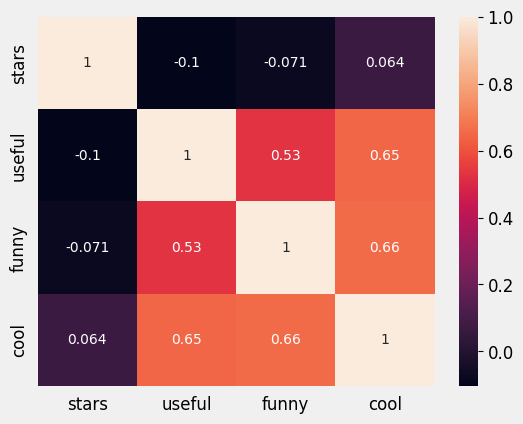

In [ ]:
# Correlation matrix
corr = first_chunk_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

#Preprocessing

Preprocessing Text Data (X values):

As the text reviews are not numerical, they cannot be fed directly into a neural network. We have to convert these text reviews into a numerical form. The two common approaches are one-hot encoding and using embeddings.

Embeddings are more natural for text data, especially for datasets with large vocabularies. It’s because embeddings provide a much more efficient representation and capture more semantic meaning. We can either train our own embeddings with our dataset or use pre-trained embeddings such as Word2Vec or GloVe.




In [ ]:
import gensim.downloader as api

# Load pre-trained word2vec model
word2vec = api.load('word2vec-google-news-300')

For our word2vec model we will not use the entire library, as it is very big. It can be scaled for higher usage if necessary.

In [ ]:
from tensorflow.keras.layers import TextVectorization

# Maximum sequence length to pad the sequences to
max_sequence_length = 100

# Limit the number of words in the vocabulary
max_tokens = 20000  # Total, including special tokens

# Load a subset of the vocabulary and embeddings from word2vec
vocab = word2vec.index_to_key[:max_tokens - 2]  # Subtract 2 for the special tokens
embedding_dim = word2vec.vector_size
embedding_matrix = np.zeros((max_tokens, embedding_dim))

for i, word in enumerate(vocab):
    embedding_matrix[i + 2] = word2vec[word]  # Leaving the first two indices for the special tokens

# Text Vectorization Layer
vectorize_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_sequence_length)
vectorize_layer.set_vocabulary(vocab)  # No need to add special tokens manually

def vectorize_text(sample):
    text = vectorize_layer(sample['text'])
    funny = tf.cast(sample['funny'], dtype=tf.int64)
    cool = tf.cast(sample['cool'], dtype=tf.int64)
    useful = tf.cast(sample['useful'], dtype=tf.int64)

    # Expanding dimensions of funny, cool, and useful
    funny = tf.expand_dims(funny, -1)
    cool = tf.expand_dims(cool, -1)
    useful = tf.expand_dims(useful, -1)

    # Concatenate along the last axis
    features = tf.concat([text, funny, cool, useful], axis=1)
    label = sample['stars']
    return features, label


# Apply the text vectorization to the datasets
training_dataset = training_dataset.map(vectorize_text)
validation_dataset = validation_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

Using layer normalization within our neural network is a good approach especially when we are dealing with large datasets where it's not practical to calculate the mean and standard deviation of the entire dataset in advance.

Layer normalization is performed during training, it normalizes the activations of the neurons within the same layer across all the samples in a batch.


Multilayer Perceptrons (MLPs), Convolutional Neural Networks (CNNs), and Recurrent Neural Networks (RNNs) are three different types of neural network architectures, each with its own characteristics and use cases.

- Multilayer Perceptrons (MLPs):
Structure: Consists of an input layer, one or more hidden layers, and an output layer. Each layer is fully connected to the next layer.

  - Use Cases: MLPs are good for simple classification and regression tasks. They are widely used in tabular data classification, where the input features are flat vectors
  - Pros: Simple and easy to understand.
  - Cons: Not efficient in capturing spatial or temporal patterns.

- Convolutional Neural Networks (CNNs):
Structure: Mainly consists of convolutional layers, followed by pooling layers, fully connected layers, and an output layer. Designed to automatically and adaptively learn patterns from data.
  - Use Cases: Primarily used in image processing where the spatial structure of the data is important. Also used in some NLP tasks to capture local dependencies.
  - Pros: Can efficiently process input data with grid-like topology (e.g., images). Excellent in capturing local and hierarchical patterns in the dataset.
  - Cons: Not very efficient with sequence data where temporal dynamics and dependencies are crucial.

- Recurrent Neural Networks (RNNs):
Structure: Consists of a series of recurrent layers that process sequences, where the output is dependent on the current input as well as the previous outputs (or hidden states).
  - Use Cases: Best suited for sequential data such as time series or natural language. They are used extensively in Natural Language Processing (NLP) tasks like language translation, sentiment analysis, etc.
  - Pros: Capable of processing input of varying lengths, and excellent in capturing temporal dynamic behavior.
  - Cons: Training can be slower and more complex. RNNs can struggle with long-range dependencies due to the vanishing and exploding gradient problems.

The RealTimePlot class is a subclass from the Keras Callback library. It can be used for visualizing the training loss in real time compared to the normal Keras plotting.




In [ ]:
def count_samples(file_path):
  num_samples = 0
  with open(file_path, 'r') as file:
    for _ in file:
      num_samples += 1
  return num_samples


# batch size
#batch_size = batch_size

# Specify the file path where our dataset is stored
file_path = 'yelp_academic_dataset_review.json'

# Count the number of samples in the raw dataset file
total_samples = count_samples(file_path)


# Calculate steps per epoch (batch_size is initialized in the beginning of the notebook)
steps_per_epoch = total_samples // batch_size

In [ ]:
class RealTimePlot(tf.keras.callbacks.Callback):

    def __init__(self, steps_per_epoch, plot_frequency=10):
        self.steps_per_epoch = steps_per_epoch
        self.plot_frequency = plot_frequency

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.batch_counter = 0

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.batch_counter += 1

        if self.batch_counter % (self.steps_per_epoch * self.plot_frequency) == 0:
            self.plot_metrics()

    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.plot_metrics()

    def plot_metrics(self):
        clear_output(wait=True)

        N = np.arange(0, len(self.losses))
        epochs_scale = N / self.steps_per_epoch

        plt.figure(figsize=(10, 4))

        # Plotting Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_scale, self.losses, label='Training Loss')
        if len(self.val_losses) > 0:
            val_epochs_scale = np.arange(1, len(self.val_losses) + 1)
            plt.plot(val_epochs_scale, self.val_losses, label='Validation Loss', linewidth=2)
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.xlim(0, None)

        # Plotting Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_scale, self.accuracies, label='Training Accuracy')
        if len(self.val_accuracies) > 0:
            plt.plot(val_epochs_scale, self.val_accuracies, label='Validation Accuracy', linewidth=2)
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.xlim(0, None)

        plt.tight_layout()
        plt.show()

# Number of batches in one epoch
steps_per_epoch = len(training_dataset)
# Create an instance of the custom callback
real_time_training_plot = RealTimePlot(steps_per_epoch)

# Recurrent neural networks

In [ ]:
print(f"Total samples: {total_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")

Total samples: 6990280
Batch size: 128
Steps per epoch: 79


In [ ]:
## Some hyperparameters in our models

# Recalling the vocab size argument
vocab_size = max_tokens

# Get a single batch of data to check the shape
sample_batch = next(iter(training_dataset))
input_sequence_length = sample_batch[0].shape[1]

Let's create a simple model:

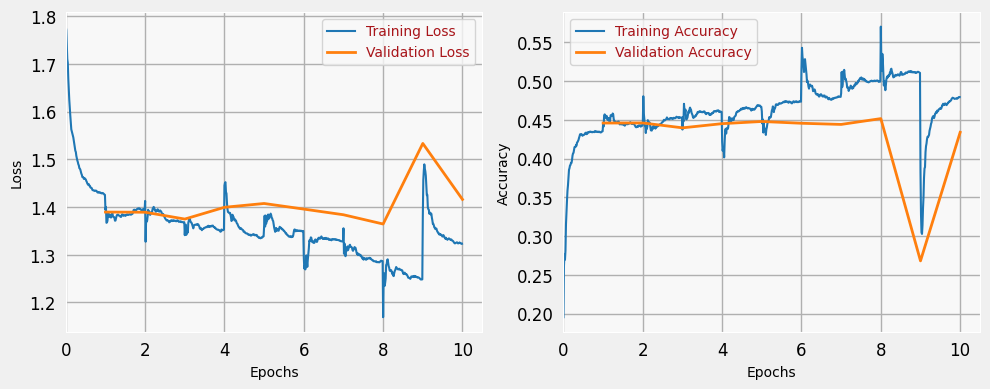

79/79 [==============================] - 9s 111ms/step - loss: 1.3230 - accuracy: 0.4794 - val_loss: 1.4159 - val_accuracy: 0.4339
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 103, 300)          6000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                23360     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 6,023,750
Trainable params: 23,750
Non-trainable params: 6,000,000
_________________________________________________________________


In [ ]:
# checking if a TPU is available and connecting to it.
# If a TPU is not available, the code falls back to using the default strategy,
# which is essentially a single device (your CPU or a single GPU if available).
with strategy.scope(): # utilizing TPU
    # Define the model
    baseline_model = tf.keras.Sequential([
        # Embedding layer
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  weights=[embedding_matrix],
                                  input_length=input_sequence_length,
                                  trainable=False),
        # Simple RNN layer
        tf.keras.layers.SimpleRNN(64),
        # Output layer with 6 units (for the 6 classes) with softmax activation
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile the model
    baseline_model.compile(loss='sparse_categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

    # Number of epochs
    epochs = 10

    try:
      baseline_history = baseline_model.fit(
        training_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        validation_steps=1,  # Since the entire validation dataset is in one batch
        callbacks = [real_time_training_plot]
    )
    except Exception as e:
      print(f'Error during training: {e}')


    # Display the model summary
    baseline_model.summary()

As we can see from our simple baseline model, it is clearly overfitting on our training data. There is a gap between training and validation, and also our validation loss is increasing.

Let's try to optimize our learning rate for further performance improvement:

In [ ]:
# Implementing learning rate decay
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

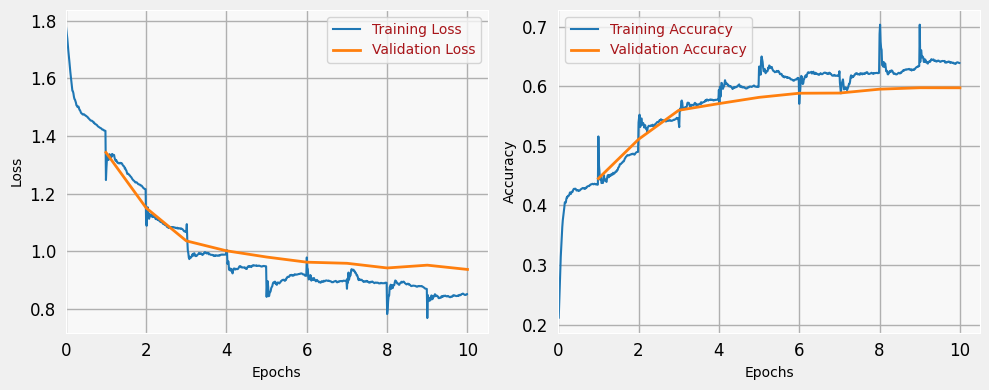

79/79 [==============================] - 25s 318ms/step - loss: 0.8521 - accuracy: 0.6388 - val_loss: 0.9377 - val_accuracy: 0.5972 - lr: 0.0010
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 103, 300)          6000000   
                                                                 
 masking (Masking)           (None, 103, 300)          0         
                                                                 
 gru (GRU)                   (None, 64)                70272     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6,070,662
Trainable params: 70,662
Non-trainable params: 6,000,000
_________________________________________________________________


In [ ]:
with strategy.scope(): # enabling TPU if available
    # Define the model
    model = tf.keras.models.Sequential([
        # Use the embedding matrix in the Embedding layer
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                  weights=[embedding_matrix], input_length=input_sequence_length, trainable=False),
        tf.keras.layers.Masking(mask_value=0.),
        tf.keras.layers.GRU(64, return_sequences=False),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Number of epochs
epochs = 10

# Train the model
history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=1,  # Use the whole validation dataset once per epoch
    callbacks=[real_time_training_plot, lr_scheduler]
)

# Display the model summary
model.summary()


Our model is now improving. We are now utilizing a more complex model with learning rate tuning enabled. There seems to be less overfitting, but still a bit low accuracy. We want to improve it, while also avoid overfitting:

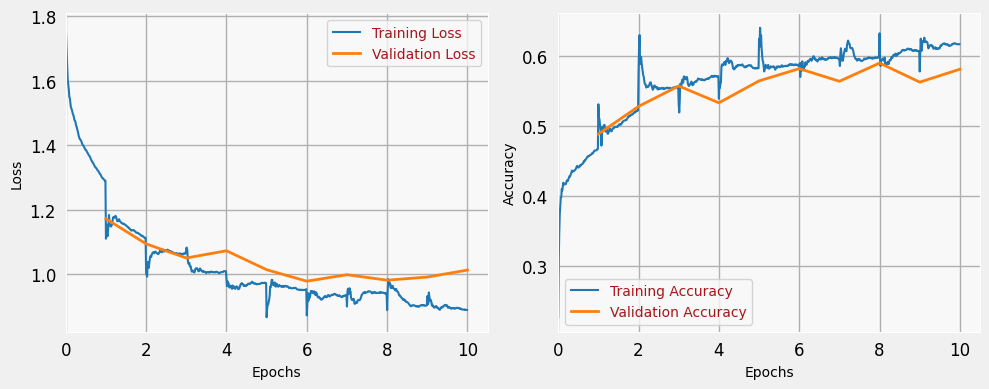

79/79 [==============================] - 48s 601ms/step - loss: 0.8896 - accuracy: 0.6172 - val_loss: 1.0133 - val_accuracy: 0.5814 - lr: 0.0010
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 103, 300)          6000000   
                                                                 
 masking_1 (Masking)         (None, 103, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 103, 128)          219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6,269,446
Trainable params:

In [ ]:
with strategy.scope(): # enabling TPU if available

  model = tf.keras.models.Sequential([
      # Use the embedding matrix in the Embedding layer
      tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                              weights=[embedding_matrix], input_length=input_sequence_length, trainable=False),
      tf.keras.layers.Masking(mask_value=0.),
      tf.keras.layers.LSTM(128, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(6, activation='softmax') # Switched from 5-> 6 (etter bytte fra gpu til tpu)
])

  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Number of epochs
epochs = 10

# Train the model (Notice that I removed the .batch(batch_size) after training_dataset and validation_dataset)
history = model.fit(training_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[real_time_training_plot, lr_scheduler])

# Display the model summary
model.summary()


Let's add some additional tuning to our model. We have now added

- Bidirectional LSTM: Sometimes using bidirectional LSTMs helps capture patterns that regular LSTMs might miss.

- Batch Normalization: This can often help improve the training process.

- Different Learning Rate: Sometimes tuning the learning rate can have a big impact. Let's use a smaller learning rate.

- Gradient Clipping: This can sometimes prevent exploding gradients which can be an issue in RNNs.



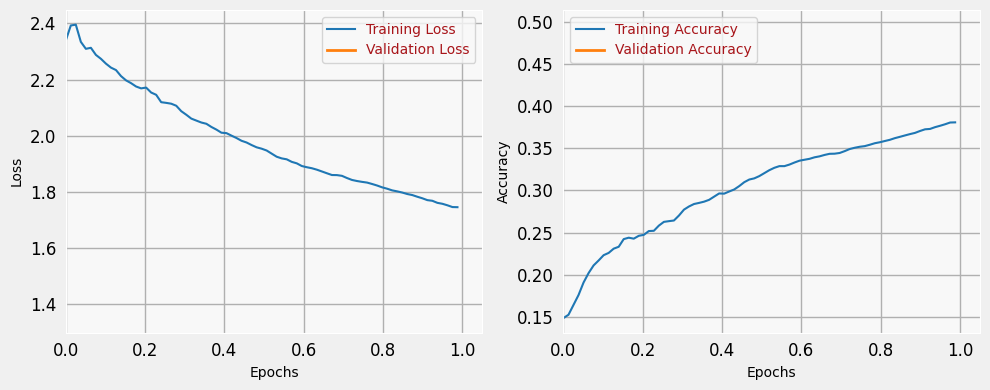

79/79 [==============================] - 104s 1s/step - loss: 1.7441 - accuracy: 0.3808 - val_loss: 1.3483 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 2/30
74/79 [===========================>..] - ETA: 5s - loss: 1.2742 - accuracy: 0.5187

In [ ]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow import keras

with strategy.scope(): # enabling TPU if available

    model = tf.keras.models.Sequential([
        # Use the embedding matrix in the Embedding layer
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                  weights=[embedding_matrix], input_length=input_sequence_length, trainable=False),
        tf.keras.layers.Masking(mask_value=0.),
        # Using bidirectional LSTM
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5)),
        BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5)),
        BatchNormalization(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Using a different learning rate and gradient clipping
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        LearningRateScheduler(scheduler),

        EarlyStopping(monitor='val_loss', patience=3),
        real_time_training_plot
    ]

    # Number of epochs
    epochs = 30

    # Train the model
    history = model.fit(training_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset,
                        steps_per_epoch=steps_per_epoch,
                        callbacks=callbacks)

    # Display the model summary
    model.summary()

## Model selection, hyperparameters/tuning and cross-validation

In [ ]:
!pip install keras-tuner

I will first try a simpler model, before trying another approach with additional LSTM-layers. Here I will use a single GRU instead.

In [ ]:
def build_simpler_model(hp): # ny
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim,
                               weights=[embedding_matrix], input_length=max_sequence_length+3, trainable=False))
    model.add(layers.Masking(mask_value=0.))

    gru_units = hp.Int('gru_units', min_value=32, max_value=128, step=32)
    model.add(layers.GRU(units=gru_units))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(6, activation='softmax'))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
from keras_tuner.tuners import RandomSearch

new_tuner = RandomSearch(
    build_simpler_model,
    objective='val_accuracy',
    max_trials=2,  # specify the number of trials
    executions_per_trial=2,  # specify the number of models to train per trial
    directory='new_tuner_directory',
    project_name='yelp_reviews_simpler'
)

# Start the hyperparameter search
new_tuner.search(training_dataset, validation_data=validation_dataset, epochs=10)

# Once it's done, retrieve the best model
best_model = new_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


In [ ]:
best_hyperparameters = new_tuner.get_best_hyperparameters(num_trials=1)[0] # ny
print(best_hyperparameters.values)

In [ ]:
new_best_model = new_tuner.get_best_models(num_models=1)[0] # ny

test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Our model did not get very high accuracy. Let's try another approach using LSTMs:

In [ ]:
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import regularizers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                               weights=[embedding_matrix], input_length=input_sequence_length, trainable=False))
    model.add(layers.Masking(mask_value=0.))

    lstm_units_1 = hp.Int('lstm_units_1', min_value=64, max_value=256, step=32)
    dropout_1 = hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units_1, return_sequences=True, dropout=dropout_1)))
    model.add(layers.BatchNormalization())

    lstm_units_2 = hp.Int('lstm_units_2', min_value=64, max_value=128, step=32)
    dropout_2 = hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1)
    model.add(layers.Bidirectional(layers.LSTM(units=lstm_units_2, dropout=dropout_2)))
    model.add(layers.BatchNormalization())

    # Added L2 regularization to the Dense layer
    model.add(layers.Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3, # this can be adjusted for more tuning
    executions_per_trial=1,
    directory='/content/',
    project_name='keras_tuner_text_classification'
)

# Start the hyperparameter search
tuner.search(
    training_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Rebuilding the model with best hyperparameters (optional, you can use the 'best_model' directly)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

callbacks = [
        LearningRateScheduler(scheduler),
        EarlyStopping(monitor='val_loss', patience=3),
        real_time_training_plot
        ]

# Train the model
history = model.fit(training_dataset,
                    epochs=30, # or the optimal number of epochs
                    validation_data=validation_dataset,
                    callbacks=callbacks)


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

## Some predictions

In [ ]:
def preprocess_text(text, funny=0, cool=0, useful=0):
    # Vectorize the text
    text_vectorized = vectorize_layer([text])

    # Convert funny, cool, and useful to tensors and ensure they have the right shape
    additional_features = tf.convert_to_tensor([funny, cool, useful], dtype=tf.int64)

    # Concatenate along the last axis
    features = tf.concat([text_vectorized, tf.expand_dims(additional_features, 0)], axis=1)

    return features

# Example text and features you want to predict class for
text = "The food at the restaurant was delicious and the service was excellent!"
funny = 1
cool = 2
useful = 3

# Preprocess the text and features
preprocessed_input = preprocess_text(text, funny, cool, useful)

# Use the model to predict the class
predictions = model.predict(preprocessed_input)

# The output of model.predict is softmax probabilities, you can use np.argmax to extract the predicted class
predicted_class = np.argmax(predictions, axis=-1)

print(f'Predicted class: {predicted_class}')
